## Study of the rank of low-rank approximation

#### Goal

As per JCGS referee's request, we study the impact of the accuracy of low-rank approximation.

We will vary rank (and relative tolerance, resp.) and see how accurate the approximated solution is,
compared to the original solution.

#### Analysis setup
Before attempting to run this Julia code, make sure your computer is properly set up to run this code by following the setup instructions in the README of the git repository.

We begin by loading the Distributions, LowRankApprox and Gadfly Julia packages, as well as some function definitions used in the code chunks below.

In [72]:
using Distributions
using LowRankApprox
using Gadfly
using CSV
using DataFrames
include("../code/datasim.jl");
include("../code/likelihood.jl");
include("../code/mixsqpnew.jl");

Next, initialize the sequence of pseudorandom numbers.

In [2]:
srand(1);

#### update a mixsqp function

We allow mixsqp specifies the rank. Whether mixsqp uses "rank" or "relative tolerance" can be determined by "lowrankcriterion" argument.

#### Write a function for simulation

Let's start with writing a function for the simulation.

In [59]:
function sim_rank(n, m, repnum = 5; minrank = 1)
    
    
    # SIMULATE the data matrix L n times m
    z = normtmixdatasim(round(Int,n));
    sd = autoselectmixsd(z, nv = m);
    L  = normlikmatrix(z, sd = sd);
    
    # RUN mixsqp without low-rank approximation
    x_true = mixsqp(L, lowrank = "none", verbose = false, sptol = 1e-10, convtol = 1e-10,
                    eps = 1e-10)["x"];
    
    # PREALLOCATE memory for the output
    df     = zeros(m, repnum);
    dxl0   = zeros(m, repnum);
    dxl1   = zeros(m, repnum);
    t      = zeros(m, repnum);
    
    # RUN mixsqp
    for rank = minrank:m
        for iter = 1:repnum
            tic();
            out               = mixsqp(L, rank = rank, eps = 1e-6, verbose = false);
            x                 = out["x"];
            df[rank,iter]     = mixobjective(L,x_true) - mixobjective(L,x);
            dxl0[rank,iter]   = maximum(abs.(x_true - x));
            dxl1[rank,iter]   = norm(x_true - x, 1);
            t[rank,iter]      = toq();
        end
        
        if rem(rank,10) == 0
            println("iteration $rank done");
        end
    end
    
    return Dict([
                (:df, df), (:dx0, dxl0), (:dx1, dxl1), (:t, t)
                ])
end

function rmean(X::Matrix, dims)
    n     = size(X,1);
    out   = zeros(n);
    for i = 1:n
        out[i] = mean(sort(X[i,:])[1:end-4])
    end
    return out
end

rmean (generic function with 1 method)

In [152]:
n = 100000; m = 100;
 z = normtmixdatasim(round(Int,n));
    sd = autoselectmixsd(z, nv = m);
    L  = normlikmatrix(z, sd = sd);

In [151]:
size(pqrfact(L, rtol = 1e-12)[:Q])

(100000, 25)

In [ ]:
srand(1);
out0 = sim_rank(100000,200, 20, minrank  = 4);

In [ ]:
srand(1);
out1 = sim_rank(100000,100, 20, minrank  = 4);

In [ ]:
srand(1);
out2 = sim_rank(100000, 50, 20, minrank  = 4)

In [ ]:
data1 = CSV.read("../data/sim1.txt", delim = ',');
df_1  = rmean(-reshape(data1[:df],50,20),2);
dx1_1 = rmean(reshape(data1[:dx1],50,20),2);
dx0_1 = rmean(reshape(data1[:dxinf],50,20),2);
t_1   = rmean(reshape(data1[:t],50,20),2);
data2 = CSV.read("../data/sim2_1e5_100.txt", delim = ',');
df_2  = rmean(-reshape(data2[:f],100,20),2);
dx1_2 = rmean(reshape(data2[:l1],100,20),2);
dx0_2 = rmean(reshape(data2[:linf],100,20),2);
t_2   = rmean(reshape(data2[:t],100,20),2);
data3 = CSV.read("../data/sim3_1e5_200.txt", delim = ',');
df_3  = rmean(-reshape(data3[:f],200,20),2);
dx1_3 = rmean(reshape(data3[:l1],200,20),2);
dx0_3 = rmean(reshape(data3[:linf],200,20),2);
t_3   = rmean(reshape(data3[:t],200,20),2);
pdat  = DataFrame(x = [4:50;4:100;4:200],
                  df = [df_1[4:end];df_2[4:end];df_3[4:end]],
                  dx1 = [dx1_1[4:end];dx1_2[4:end];dx1_3[4:end]],
                  dx0 = [dx0_1[4:end];dx0_2[4:end];dx0_3[4:end]],
                  m = [repeat(["m = 50"], inner = 50 - 3);
                       repeat(["m = 100"], inner = 100 - 3);
                       repeat(["m = 200"], inner = 200 - 3)]);

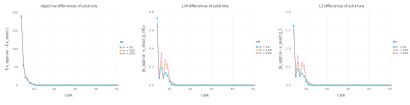

In [105]:
set_default_plot_size(41cm, 10.5cm)
p1 = Gadfly.plot(pdat, x = :x, y = :df, color = :m, shape = :m, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("f(x_approx) - f(x_exact)"),
                Coord.Cartesian(xmax = 15), Guide.title("objective differences of solutions"))
p2 = Gadfly.plot(pdat, x = :x, y = :dx0, color = :m, shape = :m, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("||x_approx - x_exact||_infty"),
                Coord.Cartesian(xmax = 15), Guide.title("Linf differences of solutions"))
p3 = Gadfly.plot(pdat, x = :x, y = :dx1, color = :m, shape = :m, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("||x_approx - x_exact||_1"),
                Coord.Cartesian(xmax = 15), Guide.title("L1 differences of solutions"))
F

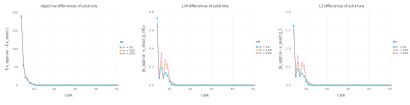

In [106]:
set_default_plot_size(41cm, 10.5cm)
p1 = Gadfly.plot(pdat, x = :x, y = :df, color = :m, shape = :m, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("f(x_approx) - f(x_exact)"),
                Coord.Cartesian(xmax = 50), Guide.title("objective differences of solutions"))
p2 = Gadfly.plot(pdat, x = :x, y = :dx0, color = :m, shape = :m, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("||x_approx - x_exact||_infty"),
                Coord.Cartesian(xmax = 50), Guide.title("Linf differences of solutions"))
p3 = Gadfly.plot(pdat, x = :x, y = :dx1, color = :m, shape = :m, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("||x_approx - x_exact||_1"),
                Coord.Cartesian(xmax = 50), Guide.title("L1 differences of solutions"))
F  = hstack(p1,p2,p3);
F